# Explore pro and cons of lexicon-based sentiment analysis

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Data sample

In [2]:
import json

In [3]:
with open('./data/yelp_sample.json', 'r') as infile:
    reviews = json.load(infile)[:200]

In [4]:
reviews[0]

{'content': "Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 'date': '2014-02-17',
 'stars': 4,
 'useful': 1,
 'funny': 0,
 'cool': 0,
 'business': 'Ue6-WhXvI-_1xUIuapl0zQ',
 'id': '----X0BIDP9tA49U3RvdSQ',
 'categories': ['American (Traditional)', 'Burgers', 'Restaurants']}

### Parsing and lemmatization

In [5]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [6]:
tokens = [[(x.lemma_.lower(), x.pos_) for x in nlp(doc['content']) if x.pos_ not in ['PUNCT']] 
          for doc in reviews]

In [7]:
tokens[0][:6]

[('red', 'ADJ'),
 ('white', 'ADJ'),
 ('and', 'CCONJ'),
 ('bleu', 'PROPN'),
 ('salad', 'NOUN'),
 ('be', 'AUX')]

## SentiWn

In [8]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [9]:
pos_map = {'NOUN': wn.NOUN, 'ADV': wn.ADV, 'ADJ': wn.ADJ, 'VERB': wn.VERB}

In [10]:
syns = wn.synsets('red', pos=pos_map['ADJ'])
for syn in syns:
    ssy = swn.senti_synset(syn.name())
    print(ssy.pos_score(), ssy.neg_score(), ssy.obj_score())

0.0 0.0 1.0
0.25 0.625 0.125
0.0 0.25 0.75


In [11]:
def average_score(token, pos):
    p, n, o = [], [], []
    try:
        syns = wn.synsets(token, pos=pos_map[pos])
        for syn in syns:
            ssy = swn.senti_synset(syn.name())
            p.append(ssy.pos_score())
            n.append(ssy.neg_score())
            o.append(ssy.obj_score())
    except KeyError:
        pass
    return np.array(p), np.array(n), np.array(o)

### Text scores

In [12]:
def tokens_score(document_tokens):
    text_data = []
    for token, pos in document_tokens:
        p, n, o = average_score(token, pos)
        td = {
            'token': token, 'pos': pos, 'senses': p.shape[0]
        }
        if p.shape[0] > 0:
            td['pos_mean'] = p.mean()
            td['neu_mean'] = n.mean()
            td['obj_mean'] = o.mean()
            td['pos_std'] = p.std()
            td['neu_std'] = n.std()
            td['obj_std'] = o.std()
        text_data.append(td)
    return pd.DataFrame(text_data).dropna(inplace=False)

In [13]:
doc_id = 10
print(reviews[doc_id]['content'])
print('STARS', reviews[doc_id]['stars'], 'CATEGORIES', reviews[doc_id]['categories'])
T = tokens_score(tokens[doc_id])

The poutines are good, the strength of the place is its variety and ambiance. I wouldn't say its the best place for poutine however.
STARS 4 CATEGORIES ['Diners', 'Poutineries', 'Restaurants']


In [14]:
T.head(5)

,token,pos,senses,pos_mean,neu_mean,obj_mean,pos_std,neu_std,obj_std
3,good,ADJ,21,0.619048,0.005952,0.375000,0.268584,0.026620,0.264463
5,strength,NOUN,9,0.138889,0.027778,0.833333,0.124226,0.078567,0.144338
8,place,NOUN,16,0.007812,0.007812,0.984375,0.030258,0.030258,0.041340
11,variety,NOUN,6,0.145833,0.083333,0.770833,0.232924,0.138193,0.326093
13,ambiance,NOUN,2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [15]:
pd.DataFrame(T.sum(axis=0)).T[['pos_mean', 'neu_mean', 'obj_mean']]

,pos_mean,neu_mean,obj_mean
0,1.674806,0.263641,7.061553


### Run over all the reviews

In [16]:
prediction_data = []
for doc_id, data in enumerate(reviews):
    T = tokens_score(tokens[doc_id])
    prediction_data.append({
        'doc_id': data['id'], 'text': data['content'], 'stars': data['stars'], 'business': data['business'],
        'positive': T.pos_mean.sum(), 'negative': T.neu_mean.sum(), 'objective': T.obj_mean.sum()
    })
P = pd.DataFrame(prediction_data)

In [17]:
P.head()

,doc_id,text,stars,business,positive,negative,objective
0,----X0BIDP9tA49U3RvdSQ,"Red, white and bleu salad was super yum and a ...",4,Ue6-WhXvI-_1xUIuapl0zQ,3.017216,1.433087,29.549697
1,---0hl58W-sjVTKi5LghGw,Ate the momos during the momo crawl.. Was the ...,4,Ae4ABFarGMaI5lk1i98A0w,1.350275,0.165064,10.484661
2,---3OXpexMp0oAg77xWfYA,Pizza here made my night... Good people and gr...,5,lKq4Qsz13FDcAVgp49uukQ,1.376431,0.191948,10.431621
3,---65iIIGzHj96QnOh89EQ,Great brisket sandwich as claimed. Weird that ...,5,6nKR80xEGHYf2UxAe_Cu_g,0.562500,0.395833,6.041667
4,---7WhU-FtzSUOje87Y4uw,"Interesting food, great atmosphere, and great ...",5,Z_mJYg3vi8cPZHa1J4BALw,2.159873,0.178829,13.661298


In [18]:
scores = P[['positive', 'negative', 'objective']]

In [19]:
scores.head(2)

,positive,negative,objective
0,3.017216,1.433087,29.549697
1,1.350275,0.165064,10.484661


### Scores interpretation

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
S = pd.DataFrame(StandardScaler().fit_transform(scores), columns=['positive', 'negative', 'objective'])
S.head(2)

,positive,negative,objective
0,-0.380789,-0.477391,-0.375100
1,-0.842574,-0.952627,-0.793509


In [22]:
decision = [np.argmax(row) for i, row in S.iterrows()]
prediction = [(S.columns[x], S.iloc[i][x]) for i, x in enumerate(decision)]

In [23]:
prediction[:2]

[('objective', -0.3751001476557547), ('objective', -0.7935087440889592)]

In [24]:
P.stars.values[:2]

array([4, 4])

### Interpretation 1: discretize scores in the stars range

In [25]:
import matplotlib.pyplot as plt

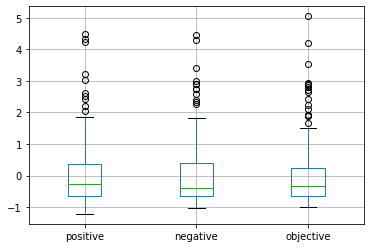

In [26]:
S.boxplot(column=['positive', 'negative', 'objective'])
plt.show()

#### Option 1: use percentiles

In [27]:
positive_thresholds = np.percentile(S.positive, [20, 40, 60, 80])
positive_thresholds

array([-0.72834831, -0.5033804 , -0.050468  ,  0.5546313 ])

#### Option 2: clustering

In [28]:
from sklearn.cluster import KMeans
from collections import defaultdict

In [29]:
k = {'positive': KMeans(n_clusters=5), 'negative': KMeans(n_clusters=5), 'objective': KMeans(n_clusters=5)}
clusters = dict([(lab, km.fit_predict(S[lab].values.reshape(-1, 1))) for lab, km in k.items()])

In [30]:
clusters['positive']

array([1, 3, 3, 3, 3, 1, 4, 4, 4, 4, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 1,
       4, 1, 4, 3, 3, 2, 3, 3, 3, 3, 1, 4, 1, 4, 3, 0, 4, 0, 1, 3, 3, 1,
       0, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 4, 0, 0, 1, 4, 3, 1, 1,
       3, 0, 1, 3, 2, 3, 3, 4, 3, 3, 4, 1, 3, 0, 3, 3, 4, 1, 3, 3, 4, 1,
       0, 3, 4, 1, 3, 0, 3, 1, 1, 3, 3, 3, 4, 3, 3, 1, 0, 1, 4, 3, 1, 4,
       3, 0, 4, 1, 1, 1, 3, 0, 4, 4, 3, 0, 3, 3, 4, 4, 3, 1, 1, 1, 0, 3,
       4, 3, 4, 3, 3, 3, 1, 3, 3, 3, 2, 3, 4, 4, 4, 1, 3, 3, 0, 0, 3, 3,
       1, 3, 4, 3, 3, 1, 3, 3, 1, 2, 3, 1, 3, 0, 0, 3, 3, 3, 3, 3, 1, 1,
       0, 3, 4, 3, 0, 1, 3, 4, 3, 0, 3, 3, 4, 0, 4, 1, 1, 3, 1, 1, 1, 1,
       1, 1], dtype=int32)

Now, we sort cluster labels according to their mean corresponding value and we map them to stars

In [31]:
cluster_scores = defaultdict(lambda: defaultdict(list))
for label, cl in clusters.items():
    label_scores = S[label].values
    for i, item in enumerate(cl):
        cl_score = label_scores[i]
        cluster_scores[label][item].append(cl_score)

In [32]:
def map_clusters(label, cluster_scores):
    k = cluster_scores[label]
    means = {}
    for key, value in k.items():
        means[key] = np.array(value).mean()
    sorted_labels = [x for x, y in sorted(means.items(), key=lambda x: x[1])]
    return dict([(x, i+1) for i, x in enumerate(sorted_labels)])

In [33]:
map_clusters('positive', cluster_scores)

{3: 1, 1: 2, 4: 3, 0: 4, 2: 5}

In [ ]:
cluster_map = dict([(label, map_clusters(label, cluster_scores)) for label in ['positive', 'negative', 'objective']])

### Final prediction (without using clusters)

In [34]:
thresholds = dict([(lab, np.median(S[lab].values)) for lab in ['positive', 'negative', 'objective']])

In [39]:
y_true = P.stars.values
y_pred = []
for i, (prediction_label, value) in enumerate(prediction):
    if prediction_label == 'objective':
        if value > thresholds[prediction_label]:
            prediction_value = 4
        else:
            prediction_value = 3
    elif prediction_label == 'positive':
        if value > thresholds[prediction_label]:
            prediction_value = 5
        else:
            prediction_value = 4
    else:
        if value > thresholds[prediction_label]:
            prediction_value = 2
        else:
            prediction_value = 1
    y_pred.append(prediction_value)

### Evaluation

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

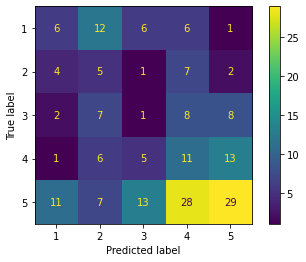

In [41]:
cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

In [42]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.19      0.22        31
           2       0.14      0.26      0.18        19
           3       0.04      0.04      0.04        26
           4       0.18      0.31      0.23        36
           5       0.55      0.33      0.41        88

    accuracy                           0.26       200
   macro avg       0.23      0.23      0.22       200
weighted avg       0.33      0.26      0.28       200



### Manually check errors

In [43]:
from IPython.display import display

In [44]:
errors = [(i, true, y_pred[i]) for i, true in enumerate(y_true) if true != y_pred[i]]
errors[:3]

[(0, 4, 3), (1, 4, 3), (2, 5, 3)]

In [45]:
for review, stars, pred in errors:
    print(stars)
    print(P.iloc[review].text)
    display(pd.DataFrame(S.iloc[review]).T)

4
Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!


,positive,negative,objective
0,-0.380789,-0.477391,-0.3751


4
Ate the momos during the momo crawl.. Was the best of the lot so decided to eat at the restaurant and the mutton thali was equally good!!


,positive,negative,objective
1,-0.842574,-0.952627,-0.793509


5
Pizza here made my night... Good people and great pizza. They can do anything you ask with a great attitude!


,positive,negative,objective
2,-0.835328,-0.942552,-0.794673


5
Great brisket sandwich as claimed. Weird that it's a gas station\/ hipster bbq lunch spot\/ hallmark store carwash.


,positive,negative,objective
3,-1.060807,-0.866138,-0.891016


5
Interesting food, great atmosphere, and great service. I like this place because there really isn't anything like this around the Charlotte area. I will definitely be coming back!

Oh, and MILK BREAD.


,positive,negative,objective
4,-0.618295,-0.947468,-0.723793


1
Boarded my English Mastiff here over New Year's.  They're closed on Sunday, so even though we got home on Sunday, we had to leave him here another day (and pay for another day) because we couldn't pick him up until Monday morning.  He got a complimentary bath with his boarding.  When I did pick him up, once I got him in the car I noticed a very pungent, musky odor.  Couldn't figure out what it was until I got him home the smell was so bad I had to leave the car windows open to air it out.  He had a greenish "material" on the underside of his tail and around his butt.  I tried to clean it off.  Let him outside and he had watery diarrhea.  I called them and asked why the stinky green stuff wasn't noticed by their groomer.  They said he did notice it and figured he had "rolled in something".  They didn't clean it all off and sent him home that way.  It was anal gland secretions, and I'm thinking why a groomer, working at a veterinary hospital wouldn't recognize that and go grab a tech s

,positive,negative,objective
7,0.284121,2.74972,1.929034


2
Granted everyone raves about this place , not everyone's experience will be the same. I go to a different place for my nails but I heard good things about this place from yelp and my boyfriend who occasionally gets a pedicure from here. Since we were next door at Costco my sister had mentioned she had wanted to get her nails done for her birthday so I recommended that we go there when we were done. 

Upon arriving we signed in and waited for our turn. I decided to change the polish on my nails so I signed in for both of us. We waited about 5 min and they took me first so I got my polish changed. A few minutes later a different girl had seated my sister and started on her full set. She placed the tip on and started to cut them and then said a different girl would finish and left her sitting there. I don't mind that u needed to leave early she should have just waited for someone to complete the job one time. As I got up from the nail dryer I saw her siting there and asked what's going 

,positive,negative,objective
9,0.664934,0.942819,2.421654


1
2Nd time eating here today.1st time was great but now i dont think so. My husband ordered chicken fried steak. The gravey tasted very strange. He scraped most of it off & continued 2eat. I ate1\/2half of 1 of his hashbrown paties which had some gravey on it . W\/in 30 mins i threw up ,w\/in 1hr he also did the same & has not stoped all day vomiting.  I finally called & spoke 2a manager, the lady was nice &suggested  i call the operarions manager. I said no . but u need thow that gravey shit away!!


,positive,negative,objective
11,-0.454808,-0.332253,-0.180218


5
Tara has been a great resource during my pregnancy! We feel so confident and prepared for birth. Thankful we found this class and recommend it highly!!!


,positive,negative,objective
12,-0.653261,-0.738432,-0.777156


5
We went yesterday as a family and had a complete blast!! I would definitely recommend going! We had Kelli as a guide and she was fantastic, she kept us all laughing and was really knowledgable about the river and history surrounding it.


,positive,negative,objective
13,-0.624701,-0.73838,-0.647744


1
Another case of the Emperor's New Clothes.  Someone of the artsy set decided that this relatively good but overpriced fare was great pizza and all the lemmings followed suit.  Will anyone tell the Emperor he has no clothes?  The limited hours, no delivery, and lack of dining area add to the snob appeal.  Don't be taken in.


,positive,negative,objective
16,-0.725374,-0.703882,-0.554003


2
It has been over 4 years I have not been to Boston Pizza, but I decided to try it out again after all my other options were closed. So I know if you come to Boston Pizza you should have the pizza, but I really wanted pasta. So I ordered plain penne with marinara sauce. In the menu it says juicy fresh cherry tomatoes with fresh grounded basil and oregano with a side of frilled garlic panini bread. Let me tell you this was not the plate that was described in the menu. I swear the sauce was Classico sauce you buy at your grocery store. There was no fresh grounded basil. The bread was a grilled toast not a panini. Overall it sucked. I now remember why I did not like it 4 years ago. I will definitely not make the same mistake again.


,positive,negative,objective
17,-0.241362,0.181794,0.321431


5
This is your home town cleaners.  The staff usually remembers my name and they are always friendly.  I haven't check around to compare prices, but the price that I pay always seems fair.  It is also in a super convenient location.


,positive,negative,objective
18,-0.773439,-0.71877,-0.593216


1
Came on Valentine's Day night having pre-bought tickets. We ended up waiting in line for over ten minutes (missing the beginning of our movie) because all of their automated ticketing machines were broken and they weren't properly staffed at the ticket counters. Just to pick up tickets that we had already bought!!! Seriously annoying from a theater that usually is so enjoyable.


,positive,negative,objective
19,-0.743652,-0.471294,-0.390603


5
Wow, we've been missing out, should've tried this a lot sooner. Our NYE at home featured pizza and tiki drinks. My bf called for take-out (I figured it would be at least an hour wait), and they told him 20 minutes, nice! It wasn't hard to find, though definitely not in a well-traveled area. Actually, had it been across Rio Salado in the Tempe Marketplace, we would not have tried it, because I HATE HATE HATE Tempe Marketplace, but that's another story. 

We got the thin crust option with italian sausage, mushrooms and olives. So good!! like other reviewers said, the sauce is unbelievable. I wish I knew their secret. 

What a great find in our (relative) neighborhood. I can't wait to try Spinato's again.


,positive,negative,objective
20,0.079033,0.769344,0.04218


3
Very small but cozy restaurant. I liked cocktail menu made with a real book as a part of cover.  Cocktail was good (I asked something like mojito which wasn't on the menu) but not out of the world...

I thought pasta was overpriced.... same for mashed potatoes.. I guess the flavor of food was pretty well-balanced but not very memorable..especially for the price.

Complimentary bread was warm and OK.


,positive,negative,objective
21,-0.065038,-0.380964,-0.361868


4
Super good food!
My friends and I ordered 2 lbs of shrimp, 2 lbs of crab legs, 2 Cajun fries, sweet potato fries, calamari, and fried catfish!

We ate it allllll up.

My only concern was that the crabs were a bit difficult to crack but then again I'm used to cracking the Alaskan crab legs.

But other than the difficult cracking, the mix of all the seasonings was just a great fusion of flavors to really individualize their seafood from anything I've ever tried.

And it was not primetime when we went so service was pretty fast!
Hope they're on top of their game when it is busy!


,positive,negative,objective
23,-0.315625,0.298195,0.057142


1
Allegiant is a disaster.  Their fares are cheap, but not cheap enough.  Our flight out of Las Vegas was scheduled to leave at 11:00 am.  We boarded and were told to de-plane because of an electrical problem.  After four hours, we get back on, only to be told that the problem hasn't been resolved.  Off again.  Eventually, we're told they are getting us a different plane and that we will take off at 6:00.  We'll see.

The issue is not that there was a problem with an Allegiant flight.  The issue is the consistency with which this airline has problems.  I do not believe it is an exaggeration to say that half of its flights are delayed or cancelled.

Update:  6:30 pm and the boarding estimate is now 7:50 pm.


,positive,negative,objective
25,-0.702637,0.286569,0.022643


5
The food here is fantastic and the service is exceptional. Certainly a 3.5 star "diamond in the rough!" I can't wait to dine here again!


,positive,negative,objective
26,-0.962742,-0.595243,-0.761024


2
I went here twice and after leaving with a "eh" feeling after both visits decided it was time to switch to another dermatologist.

My first visit I specifically requested Dr. Woodson herself after reading a lot of neutral to negative reviews for her PA and NP. After filling out a ton of paperwork (most of which was not very welcoming- I think I signed about three different forms promising I would definitely pay my bill or be sent to a debt collector. I get they want their money, but what a way to greet your new patients!) I went into the exam room and lo and behold PA John Notabartolo walks into the room. Since I was already there I just went with it. He examined my skin (I went in for some mild adult acne) for less than ten seconds, told me basic skin care advice that I've known about for years, and then wrote me some prescriptions. The whole visit with him lasted about three minutes. No real suggestions or overview of my current skin care regime, no explanation of the possible caus

,positive,negative,objective
27,4.321043,4.306551,5.051427


5
Every time I come here the food is perfect !!!!! One of my favorite sushi spots in vegas! They make it right every time always happy to come here


,positive,negative,objective
29,-0.648073,-0.907664,-0.745711


5
Very nice seats, the sound is ok, good prices I still prefer the theater out in Robertson or even lowes


,positive,negative,objective
30,-0.537345,-0.785046,-0.849449


5
Oh my.. I had the best meatball sandwich I've ever had in my entire life at this restaurant. We were visiting only for a few days and I wish they had another restaurant like this local to me here in Virginia. This was a five-star place in my opinion. I loved it. Everything was delicious


,positive,negative,objective
31,-0.547099,-0.692212,-0.612702


5
My husband and I went here on our honeymoon to enjoy a nice dinner, not to mention that we both love chef Ramsey. Eating at one of his restaurants was a bucket list item for us. We were not disappointed at all.  The food was beyond perfection and the service was spot on!!  The beef Wellington and vanilla cheesecake were to die for. If I could give Gordon Ramsey Steak in Las Vegas 10 stars I would!!


,positive,negative,objective
32,-0.398199,-0.682102,-0.537305


4
I had never tried Colombian food before, so I wasn't sure what to order.  (My palate is as American as it gets.)  The staff was very helpful, and I decided on the Churrasco de Pollo.  It was savory and delicious, the side of plantains added a mildly sweet twist, as well.  I will certainly eat there again.  The food is prepared while you wait, so it's best to call in your order.


,positive,negative,objective
34,-0.036474,-0.191845,-0.375205


4
Came here for my first Yelp Office Hours last Thursday. I was very impressed with the layout of the place. It is very open and you don't feel like you are sitting on top of the stranger next to you. I feel like most coffee shops are really small and claustrophobic, ie Starbucks.  Lola's bucks that trend.

Dallas G, Richard Z and I decided to make a cameo here before our #ThaiThursday at Yupha's.  I didn't want to ruin lunch with a coffee, so I went with a yerba mate tea.  It wasn't served the traditional way with a bombilla, but it still tasted good.  The Yelp group occupied a large table in the center of the space.  Good conversation was had by all and new friends were made.  Sarah G brought some baked goods that knocked my socks off.  I have already requested that I get cookies sent to me on a weekly basis. Crosses fingers.  I will surely be returning and I heard they are opening a second location at 3rd Ave and Roosevelt.

Thanks Gabi for picking up the tab.  Can't wait to make th

,positive,negative,objective
35,0.351269,0.699218,0.50754


3
Voting three stars for now, because it hasn't been opened for a full week so I still want to give it the benefit of the doubt and return due to my love of sushi and Lakewood. 

Atmosphere was nice, I love the Lakewood vibe and this place fits right in.

Drinks were good, strong. One of the perks of waiting is getting just a little tipsy. 

My waitress Natalie was nice, can't really blame her for the long wait, but she did everything we asked.

Three problems.

The wait: Now I don't want to be too hard on them because I can imagine how difficult opening week is before everyone gets into the groove of things. But we ordered our appetizer ( which is two veggie egg rolls ) and two maki rolls ( one Lakewood maki and the one Crab Rangoon) at the same time. It took about twenty mins for the appetizer and then another forty mins on top of that for our maki rolls. If the wait will be this long I can only hope they will provide some type of munchies to keep us distracted. Like wontons and dip 

,positive,negative,objective
37,2.207957,2.918496,2.249562


3
Average B-dubs but better than most around NEO. Stopped in tonight before the Lutheran West FB game and everything was good. The orders for our party of 8 came out hot, reasonably fast, and most importantly...correct. The service was also really good for being as busy as they were. I still think b-dubs is overpriced though. We really only come here bc it's convenient before football games.


,positive,negative,objective
38,0.242215,-0.478892,-0.424368


4
I booked a deluxe suite in vdara for this past weekend for two nights and I realllllllly like this hotel. 

I was a little worried at first because it is a little off the strip behind cosmo but honestly, its not an issue at all. You can walk through cosmo super easily and get to the strip and everything else. And if you can't you were probably going to cab it anyways.

I love modern and clean and windows and open space. And this weekend when I came they already had up their christmas decor which I also loved! It made me feel so happy!!!!! :D 

The suite opened up and theres the kitchen area with the microwave, sink, refrigerator and stove. (Lets be real we weren't actually gonna cook ) but the fridge is good for storing alchyyy ;)

I liked this room bc we had a few girls in there and they had plenty of mirrors both full length and normal. The bathroom was nice. a separate tub and shower with a sliding door. to separate it from the bedroom. The couch turns into a sofa bed as well so y

,positive,negative,objective
39,1.05505,0.562656,0.810924


4
I like the food, it was really fresh. The service was also on point and it was a full house. The beef is really good, any of them. The fried rice feeds about 3 ppl. I love this place, I come here often. And always bring ppl here who come to Vegas to visit, they all love it. The price is also very reasonable. For 2 ppl I usually spend about $40 but leave STUFFED.


,positive,negative,objective
40,0.109371,-0.596303,-0.385022


4
Pasión por Arnalado. Tengo una amiga que vive cerca y cada vez que voy a su casa es visita obligada.

La relación precio-calidad es una cosa increíble. No existe, en serio. Febrero 2016 y el kilo está 130 pe. La heladería está a la altura de las grandes marcas y los precios parecen del 2008. 

Eso sí, hay que ir preparados porque se llena y mucho. Un día de calor puede haber cola hasta afuera y seguir toda la cuadra. Pero no se desesperen, porque Arnaldo es taaaan groso que te atienden rapidísimo, avanzás enseguida y, de todas formas, la espera lo vale!


,positive,negative,objective
41,-1.216634,-1.014491,-1.001663


3
This show wasn't super extravagant but Lance Burton is one of the classic icons in the magian world.  He's funny and entertaining.  This is just one of those shows that you should do once on one of your vegas visits.  When i watched the show there were a lot of kids in the audience and a couple of loud drunks so be aware of your surroundings :o)


,positive,negative,objective
42,-0.60527,-0.46732,-0.555424


5
This place has an awesome vibe. Brett Rubin's B-day bash this Sat nite after 11, with Brett spinning! A must attend... Brett is the best in LV for deep House & TechHouse.

Plus the grill is open, and Lando and Gabe promise an awesome experience. You've been warned; miss this one and you'll kick yourself! He spins at DISTRIKT.


,positive,negative,objective
43,-0.349207,-0.583552,-0.656689


4
An absolute favourite of mine....I don't understand why this place isn't getting better reviews. I love love Thai food and Pi Toms does it better than any place I have ever been to, hands down. 

I usually order Pi Tom's own version of Pad Thai....they also have a 'Traditional' version too but I prefer the restaurants own and it is delicious. The ingredients for both dishes are practically the same but Pi Toms dish uses a lighter, more subtle sauce (not ketchup like most traditional pad thai dishes) leaving the flavours of the other ingredients to be fully appreciated. They give pretty decent portion sizes....I rarely finish the entire thing but makes for a great lunch the next day...

The mango salad here is to die for! Really fresh ingredients makes this salad extra special and they use a delicious sweet dressing. 

There are many Pi Toms around Toronto but this one is my personal favourite...its on a nice, fairly quiet street just off Yonge and Wellesley , and has a cute patio com

,positive,negative,objective
44,2.627937,0.771676,1.02522


2
We have been going here for several years and every time the only thing consistent is the rude staff behind the front desk.
My grandson was visiting from Cali for spring break and wanted to go bowling yesterday.  I am on their email list and had received a coupon for two hours of bowling with shoes, food, etc for $7.99.  I asked for the special rate and was very rudely told that it doesn't apply during spring break and that lanes were $3+ and shoes were $4.50.  When I asked about who has spring break now he rudely replied Paradise Valley schools.  Really????  This was Scottsdale, wtf?
So I paid over $30 for three of us to bowl.  When I asked for two lanes (one w\/ bumper for grandson) he acted really put out.
We had a good time, but both my daughter and myself have our own shoes and I felt ripped off and hate rude workers, so I was mad.
Then afterwords we went to the game part of the place and almost every game was broken or did not give out tickets.  My grandson wanted to play ski b

,positive,negative,objective
45,0.6784,0.938872,1.279607


3
A word of caution! Don't use their ATM if you have  a credit union. My Fiancé and I visited last Saturday. We expected to grab a to-go burger, just to say we tried it. We ended up staying over an hour and having an absolute blast. Nurse Stephanie was fantastic. She is perfect for her job and went above and beyond for us. The food was amazing, although, if you are not used to the grease, be careful (if you know what I mean). The only reason I gave 3 stars is, when I tried to take money out of the ATM, I got an error message. So my Fiancé used his card and we thought everything was fine. Come to find out I was charged for the money I never received. I contacted the grill and am waiting to hear back, hopefully we will resolve this quickly and I can up my review to 5 stars!


,positive,negative,objective
46,0.278739,0.133956,0.173297


5
This is a great place to get affordable  workout clothes and shoes. Everyone is really down to earth and helpful. My favorite part of the mall.


,positive,negative,objective
47,-0.858569,-0.914334,-0.794484


5
Most romantic spot in LV. Great for people watching. Nice menu and very good food and service. A must if you come to Las Vegas.


,positive,negative,objective
48,-0.59712,-0.82576,-0.798437


4
For a quick lunch, grab the sides! Chicken is well peppered, salad is crispy and cold. Only reason it's not five stars is because I haven't tried any main dishes! But I do want to... to be continued...


,positive,negative,objective
49,-0.817081,-0.60399,-0.640373


1
Very unimpressed by their pad Thai.. one of the worst I have had.. lacks flavor and beef tastes like rubber.. I ordered though UberEATS so I don't know if in store it's different but won't be returning for sure!


,positive,negative,objective
50,-0.874921,-0.219499,-0.702198


5
Over the years I have seen Lisa for reiki and reflexology 4, 5 times... and there will be 6th, 7th, 8th time. And so on.  Very intuitive, caring person,  powerful presence, she is one of those wise women you NEED to have in life. Even if for an hour. I always leave her studio balanced, grounded, encouraged, inspired and empowered. Thank you for your work, Lisa!


,positive,negative,objective
51,-0.561607,-0.749915,-0.344817


2
It's cheap for what it is, but there are many options in the area which delivers the same quality and price.

I'd rather go elsewhere if I'm craving for some good chinese bbq meats :P


,positive,negative,objective
52,-0.717589,-0.61369,-0.735472


1
I just called this North york Location at 416-446-1045 and was told i cannot make a reservation the whole day. I told the guy 5 minutes ago i spoke to a lady that i could book until 5:30pm. He told me well the lady who told you that must be misinformed cause she doesn't know how busy we are. I said well you guys should better train your staff because 5 mins ago you guys told me i can book and 5 mins later you are giving me attitude that absolutely you guys cannot book even before 5:30pm. this is ridiculous and the man who told me was very rude. Don't even have to come into the restaurant to learn your good training and customer service. I know I won't be going into this restaurant and obviously they don't need me as they are too busy


,positive,negative,objective
53,0.4429,0.019902,0.123078


5
Place is amazing, Dr roach is the best!! Staff is super friendly i think we have found our new vet.


,positive,negative,objective
54,-0.683893,-0.796242,-0.85913


2
Unbelievable how the employees that work in the front part of the store can be so nice and helpful, but the guys that work behind the counter in the back  (parts?) can be such assholes. When we need to buy something for our trailer, we avoid the back of the store at all costs.


,positive,negative,objective
57,-0.861552,-0.556233,-0.529914


1
The main reason we came here was to try the lane buster mason jar dessert. We had family visiting and we figured we would show them a little bit of what Charlotte had to offer by taking them to what sounded like a very unique Bowling alley. What a horrible regret. The service was terrible. It was incredibly hard to locate our waitress. We have twin toddlers which do not have an ounce of patience and even though I came fully equipped with snacks and drinks they all ran out before we could get our food. The food not impressive, my husband's burger was dry(for which we had to wait 30 minutes for ketchup). My quesadilla was extremely greasy and our sweet potato fries were cold. It took one of the family members I brought having to ask 3 times for a refill on her Sprite for which she got when she was done eating her sandwich. By the time the desert came I was so discouraged that I didn't even want to try it. I am completely disappointed at this establishment and embarrassed that I brought

,positive,negative,objective
61,0.121811,1.525867,0.587043


4
What's with the reviews about the cost? If you're on the strip, it's going to be expensive. I enjoyed great service, a terrific waiter who was not pushy & made great suggestions. The garbage fries were perfect to share, the truffled cheese on my waygu Kobe & port wine reduction gravy made for a perfect burger. The spiked vanilla shake was yummilicious & blended nicely with the vanilla vodka.

My husband enjoyed his caprese burger, too! Will be back!


,positive,negative,objective
62,0.246297,-0.636372,-0.239898


5
The fastest in\/out I have ever experienced at any discount tire... and it was done right with the correct psi.


,positive,negative,objective
63,-0.954259,-0.927461,-0.851974


3
Excellent food, not as good as fish and chips from Australia but excellent none the less. Wish they had pineapple fritters or potatoes scallops..
I did Sri e though girls are pleaaant, but while waiting for my food I hear the 'F' word, thankfully 4 year old was not on the car. Talk about boyfriends, substitute teachers and so on. If it were my business or I was the manager I'd have the girls engage with the cuatomers, how is your day going is this your first time, no up selling nothing. .


,positive,negative,objective
64,-0.166683,-0.683141,-0.116657


5
Eye have found the best place in town for contacts and glasses!!! I made an appointment in April and the eye doctor gave me a prescription for both contacts and glasses.  I bought contacts in April.  They sent them to my house; so convenient.  I went back yesterday and I bought new glasses.  The process for the doctor exam and the purchase of my contacts and glasses were quick, easy, and efficient.  By far, the best experience I've ever had purchasing contacts and eye glasses ever!!!


,positive,negative,objective
65,-0.20796,-0.629153,-0.138495


1
Well, I am back.
And it will definitely be my and my family and friend's last time back. 

A whoppin' one star! Here's why:
1. Their pho is still good. Not my favorite, but it's still good. Our server was a nice guy. 
2. We order a flat noodle stir fry dish -- so greasy and 60% of it was white onions, not noodles. Did we order a plate of onions with some noodles and shrimp in it??? Plus, our order was placed wrong in the first place, so we had to wait again for the correct order. Our server was apologetic, so that's fine. 
3. I ordered thai tea, but they were out of half & half, for about another 20-30 minutes. You want to wait? Yeah, sure. Half&half gets delivered....eventually, our server remembers and asks if I still want thai tea. Yes, please. Never got it. But I ended up somewhere else after to fix my craving, and I'm super glad I went somewhere else to splurge my money. 
4. Substituted two orders of pho that had eye round steak for beef meatballs in one and tripe in the other. 

,positive,negative,objective
67,2.419291,3.413076,2.92809


4
Mind you the wait time could be loooong! So bring someone who is diamond or 7 star member with you if you can. So u can skip the line. All the sea food was very fresh and tasty. I love their cooked oyster! Desserts are very yummy, love their flan!! So many choices. Service was okay, our server didn't bother to check on us much but the table next to us.


,positive,negative,objective
68,-0.071129,-0.308029,-0.34371


5
I've been a local in the area for the past 7 years and it has been my experience that the employees here have always treated me in a courteous manner. I stopped in again today and Lisa assisted me with Pest Control products. Her product knowledge is vast and that, coupled with her genuine 'Southern Hospitality' type personality helped to brighten my day. Great customer service is hard to come by and it really does make a difference!


,positive,negative,objective
69,-0.479176,-0.515503,-0.343128


3
Okay, I have been meaning to write this review for a while. 

Spas of AZ have 4 Valley locations. There website is different than their name. Their website is: http:\/\/acrylicspasaz.com\/

Completely different than their store name... ANYWAY! My wife and I go in to the store after several happy hour drinks one day at Logan Grill (right next door) and we want to buy a spa. We had been talking about this for a while and we thought since we had extra liquid courage that we could finally just go and pick one!.

Well, spas are not cheap. Cheapest tub in the place at that time was $3,500. We had our eye on one that didn't have water in it, so all we could do is just imagine what the jets felt like. The sales guy Forest, explained to us that we would love it and yada yada. All we said we wanted is strong jets to massage our sore muscles after the gym or other physical activities that we do. We ended up buying one for $200 bucks more that the cheapest one - paid in full - had a 30 day fix w

,positive,negative,objective
70,4.239603,4.449774,4.215529


5
Over two years later and I still have nothing but great things to say about this business! I am very surprised that others haven't posted yet?


,positive,negative,objective
71,-0.95985,-0.635596,-0.802782


1
Arrived at 1:40pm on a Sunday just to get flat out rejected from the restaurant, didn't even try to seat us. 

The host claimed that their kitchen was "closed" and will not take requests until 3:30pm, upon which they would re-open and their lunch would start.

1. Where does it say that there is a midday break? Their business hours say 8:30AM TO 8:00PM continuous. No where does it say there is service stop of any kind. I checked yelp, website and google.
2. We were thinking of going there for brunch; admittedly, we did arrive a little close to the end, but the website menu says service is available until 2pm SHARP. Which we fully complied with, so why would they close early?
3. How can a kitchen just close down during late-lunch hours and not have any other options? 

Absolutely despicable.


,positive,negative,objective
72,-0.516403,0.169309,0.278112


4
Great happy hour pricing and food. 
Make sure your entire party is present or they won't seat you.


,positive,negative,objective
74,-0.849541,-0.873951,-0.81951


5
We went to Captain's Boil yesterday, and couldn't help racking up a huge bill! We ordered lobster, clams, snow crab, king crab, dungeness crab (all with the Captain Boil sauce) and cajun fries. Everything ordered was superb. Every member of the staff was extremely helpful. Like another review I saw, it's recommended that you come before 6:00 PM to nab a seat.


,positive,negative,objective
75,-0.656695,-0.882795,-0.461181


5
Ann is the BEST! We came in and wanted her to choreograph a dance for our wedding and it turned out amazing! We can't thank her enough. Im so excited for everyone to see it. Their prices for classes are also very reasonable. I will definitely be back.


,positive,negative,objective
77,-0.411889,-0.730576,-0.643114


5
I love coming here! The food is great and I love the service. I always ask for savanna when I come. She is extra helpful and gives me a five star experience every time!


,positive,negative,objective
78,-0.515965,-0.914021,-0.711912


3
This place is definitely for hipsters, which me and my boyfriend are not. It is well decorated and feels really "cool" but the food wasn't anything to rave about. One of those places that people go to just to say they've been there, I guess. I went for dinner, and the dinner menu is actually smaller than their lunch menu? I thought that was weird. All the things that I saw on yelp reviews and I actually wanted to try were not for sale at the time I went. I settled and had curry, it was alright. So they get an okay review, because everything there was okay. Nothing bad, just nothing special.

Oh I lied, there was one thing that was pretty great. We paid four bucks for their self-filtered water and it was actually really amazing. LOL. I know that sounds like I totally got ripped off but the water was literally tasteless it felt so weird to drink. Quite the experience. I wouldn't go back for water, but I am glad I tried it once!


,positive,negative,objective
79,1.135954,0.755618,0.63959


5
Super friendly & made me feel comfortable w\/ almost no clothes on.


,positive,negative,objective
80,-1.006544,-0.862429,-0.939425


4
First visit and I'm not at all disappointed. I can't tell you how many times I walk by and just take for granted that it's there. "I'll get there sometime" kind of attitude. Jeez, I'm mad it took me so long.
Sushi is just amazing and super fresh. And oh so affordable!
Can't wait to get back!


,positive,negative,objective
81,-0.533827,-0.05577,-0.431558


3
I've gone to Eva Nails & Spa for the last month or so to get my nails filled. It's a nice little place. They offered me water every time I'm there.  
As for my nails, they always come out looking great. I get the white tips with pink polish on top. I can usually go about 2 1\/2-3 weeks between fills. They know exactly what I want and how I like my nails. I do get annoyed that one of the nail tech's son (about 1-2years old) runs around the shop. He snuck up and took off with my phone one day and then screamed when they took it away. Another time he tried to get it but I was able to get to it before him. It's a little annoying they have him running around when customers are there. He plays with the stuff on the other tables and gets into things. I think they should either not bring him, or hire a sitter.


,positive,negative,objective
83,-0.037465,0.387913,0.490726


5
These guys did an amazing job on our front yard! We needed the front yard and sides of the house cleaned up and it looks amazing. They pulled all the weeds, blew out all debris, sprayed weed killer and trimmed all the shrubs. I will most definitely be using their service again in the future!!


,positive,negative,objective
84,-0.656697,-0.446646,-0.464775


1
I waited for my order for over 10 minutes. I ordered two chicken finger kids meals and two adult meals. Had to pull forward and wait another ten minutes for food. When I got home they didn't give me my kids meals.


,positive,negative,objective
85,-1.151214,-0.791026,-0.581003


5
How I love you Waffle House....

When I see your awkward plain square yellow letters...W...A...F....F....L...E.....H....O....U....S...E....I truly light up inside.....you have been my inspiration to continue driving on many of my road trips.....I just keep going and going and going...from one waffle house to the next through out the whole country......sometimes I am unfaithful to you and swing in to Cracker Barrel...but you always get me first..they get your sloppy seconds......Yes I can see your sign in my mind right now.....

I swing in and almost sprint inside....I force myself in between to fat smelly truck drivers at the counter...and then I wait for the oh so ugly staff with the lazy eye and missing teeth to ask my for my order.( I wonder if having a lazy eye is a job requirement at Waffle House ).....no need for a menu...I know....I always know.....I want the cheese egg special that comes with raison toast ,apple butter and yummy ass hashbrowns ( be careful in some states it c

,positive,negative,objective
88,1.433177,2.994267,1.91147


4
Grabbed a beer post-farmers market. Great spot with Wisconsin roots and solid service.


,positive,negative,objective
89,-1.080925,-0.941541,-0.863061


5
Small quiet street parking available. The food was carefully done they do take their time. Be ready for a short wait. If you're in a hurry this isn't the place for you. Like being in your mother's kitchen. Close Quarters happy people a little noisy but all worth it. Food was carefully done. Lots of choices. Love getting the waffle poached eggs bacon and a good cup of coffee. That's what life is made of small memories socializing happy people Good Times.


,positive,negative,objective
91,-0.067154,0.033684,-0.100678


2
Strike 1: our reserved, non-smoking room was not ready at check in. We were given the excuse that 'we cannot guarantee specific room types, rather do our best to fulfill special requests.' That's BS in my opinion. After a long drive, having to wait any amount of time for a room to be ready is not okay. 

Strike 2: the room was not cleaned well, aside from a made bed, empty trash and folded towels. Actually, it looks like it hadn't been cleaned well in quite some time. Lots of dust and random liquid stains in the room. Gross. The walk up to the room was also disappointing, the symbols they use as lighting fixtures were missing throughout the halls, it looked very sloppy and unkept. 

Strike 3: for the price we paid, we would have stayed closer to the strip at a chain hotel (embassy, Westin etc. etc. ) with better cleanliness. Although the maids were nice, they looked a little overwhelmed. 

On another note, the food at Mr. Luckys was good. The staff were nice and the food tasted great

,positive,negative,objective
93,1.548805,0.895949,0.598666


5
I don't usually take my clothes to the dry cleaner because it is such a hassle. I had a formal though and needed my suit cleaned. I brought some other shirts and pants along since I was going anyway.

I am super happy with the results. They starched and pressed everything perfectly. But amazingly they removed a grease stain from one of my shirts that I assumed was impossible to remove. I didn't even ask them to do it but they did it anyway!


,positive,negative,objective
94,-0.584705,0.014134,-0.299942


5
NICE!!! I called for information, Randy took the time to walk me through the options...even telling me how to do it myself if I wanted. I tested out his thoughts and then called him back. He was prompt, polite, educational and efficient!!! The best I've seen! THANKS!!!!


,positive,negative,objective
95,-0.325429,-0.61514,-0.634776


3
24 hour tacos? Yes please.

This place is a modest spot in the middle of a strip mall, seats about 2 dozen, and has a little self serve (I think? I hope?) mini buffet nook for peppers and veggies and whatnot. 

The dude working here was nice enough, but the real point we care about is the food, huh? 

I got the shredded beef burrito, which was tasty, but wet\/soggy and not exactly overly flavorful. We also got the chicken chimichanga, which was huge, stuffed with a ton of chicken and cheese. Lastly was the shredded beef enchilada plate, which had a ton of onions, despite being told otherwise. 

Overall, if you order a plate, the portions are huge. 3 stars because it's satisfying and a decent price, but not memorable.


,positive,negative,objective
96,0.066105,0.396205,0.306464


5
I love this place! The food is fresh and the portions are huge. So glad they have a 2nd location


,positive,negative,objective
97,-0.85473,-0.691829,-0.807817


5
One of my favorite museums.  It is several floors and the best part is that they let you take pictures (and I proceeded to photograph every piece of work on display).  I was there close to 3 hours which is rare.  They regularly rotate his work and what you see if probably just a fraction of it.  I can't wait to return!


,positive,negative,objective
98,-0.741845,-0.70853,-0.442694


1
Excited to go to stop by a new fabric store and the hours on the door was posted as being open at 10 AM, got there at 10:15 and it was dark inside, no lights on and 
the door was locked.... looked really small and not too many bolts of fabric.  Won't be driving out there again.


,positive,negative,objective
99,-0.83446,-0.422816,-0.408194


5
Great price on a JVC double din for my Vette.  Nice guys and pretty quick.  You need an appointment for Saturday work I think.  Saw a review about someone complaining about low end equipment.  You get what you pay for...if you pick low end stuff it's not the shops fault.  I didn't see much low end stuff while I was there mostly name brands like JVC and Kenwood.   I recommend these guys.


,positive,negative,objective
101,-0.539712,0.134176,-0.310536


5
This is probably the 6 th time me and my boyfriend coming here. There hamburgers are awesome and so are there wings. We found this place by going on yelp. Boy am I glad that we choose this place and the waitress Jess is GREAT!!! They have the fishbowl drink specials on Fridays $10. And they are normally $15. Either way worth every penny not watered down. They are 84 oz. always a great time


,positive,negative,objective
102,-0.507067,-0.764945,-0.436043


5
Caveman has always been helpful and generous with their time to help get my projects right. The first product I ever purchased from them was an enlargement of a CD cover that was being blown up to poster-size so I could give it to my wife as a gift, and it was reasonably priced and turned out looking great. I'm currently in the design stage of having business shirts made for my computer repair company, Working Technologies. I'll post some pictures up once they're finished! Thanks for being a quality, independently run company, places like this are a rare breed these days and deserve more business.


,positive,negative,objective
105,-0.210484,-0.419821,0.046965


3
I'm giving this place a 3.5! (and that's a good thing)

Whenever I'm craving Korean BBQ and don't have much $$ I go here strictly for the price. It's a lot more affordable than other ayce places which will cost me (+ tip) around $30 for dinner. The meat and banchans are pretty good, not crappy at all. They do lack desserts but so does Sura. I guess desserts aren't highlighted in Korean BBQ because people are too stuffed with meat and ran out of room for anything sweet afterwards. Everything they serve on the buffet may not be an A+... maybe a B- 

They have at least 4 different marinated meat selections and another 3 or 4 "dry" meat which includes beef, pork and chicken. They also serve seafood such as shrimp and squid. They have all sorts of "salads" or cold dishes, along side other appetizers? Such as pot stickers and grilled fish. They also serve sushi rolls but I never give those any attention. If I want to eat sushi, ayce Korean BBQ (or any buffet in general) ain't the place. I 

,positive,negative,objective
106,0.654741,0.895284,1.064569


5
Really enjoyed taking my niece (7 years old) to get pedicures. Nice people, good pedis! $20 isn't a bad deal :D


,positive,negative,objective
107,-0.539393,-0.644818,-0.813605


4
I absolutely love this bakery and I am so glad it is too far to go to on a regular or I would be big as a house LOL!. I highly recommend the butterscotch ganache and the coffee and donuts or just the donuts without the coffee LOL! You'll go away happy that's for sure!


,positive,negative,objective
108,-0.155481,-0.563805,-0.585407


5
Great service and seen in a timely manner. Came in with back spasms and pain. Left with all the meds and exercises to get over it. Did not need to see anyone else. Felt completely better soon after.


,positive,negative,objective
110,-0.688569,-0.406258,-0.662132


5
Great pulled pork sandwiches. Perfect for a take to go meal or a quick sit down. The Bbq sauce was pretty good, and their unique sides to put on the sandwich like safe were tasty.
     They were central and perfect to grab a bite of you were heading over to the park or to simple hang out.
     The only complaint we had was that the place didn't serve beer, only non-alcoholic unfortunately. 
     We would definitely venture here again our next trip to Edinburgh


,positive,negative,objective
113,0.03994,0.123978,-0.268075


4
While visiting Pittsburgh from NY had the good fortune  of dining here. Excellent gastropub. Food was great with an awesome beer selection. I highly recommend this establishment if you're in the downtown pittsburgh  area


,positive,negative,objective
114,-0.171752,-0.846735,-0.721175


5
These guys are great!  They are honest, only sell you what you really need.  Love working with D and D, thanks!


,positive,negative,objective
116,-0.812479,-0.767732,-0.894505


3
I've been coming in to Drop Bar for over a year, and service is consistently good. 

I get "free well drink" tickets every week, when I cash my paycheck, so I always pop in here for a quick shot of whiskey or tequila.

Their well drinks are not great, but they're higher quality than some places...

Its dark, and sometimes they have live musicians, which is fun.  

I can't comment on the prices, because I always use my free tickets here, but the service is definitely good...I'd probably stop in here for a drink without a ticket, if I'm in the area.


,positive,negative,objective
118,0.184699,-0.383873,0.013552


2
The line for this place can be horrendous, and really, it's not that worth the wait.  Most of the crowd can be "trendy" and stuck up, though some people are genuinely there to have some fun.  Bottle service isn't worth it, and the music is pretty average for a club.  The place can get REALLY packed, which provides for a wide assortment of people.  The drinks are expensive, but they're made pretty well.  This is a decent spot to hang with friends, but in my opinion it gets too crowded with people who are trying too hard to seem important.  I'd go elsewhere to just hang and have a good time.


,positive,negative,objective
119,0.565321,0.122933,0.107346


1
Terrible.  Very disappointing. We went for ramen and it was very plain and tasteless.  Hard boiled egg instead of pickled.  Dry pork instead of pork belly. Asked if they could make just a plate of noodles for our 3 year old and she said no.  We don't have noodles.  Well what is in your ramen?  Services was just plain rude.


,positive,negative,objective
120,-0.445422,0.221483,-0.520636


5
If you're lucky enough, Adam Thompson will fix all your electric problems! Adam Thompson is the BEST of the BEST!


,positive,negative,objective
122,-0.699258,-0.81395,-0.900769


1
This review is for T-mobile in general. 
I cant make phone calls on my phone. people cant hear me. they cut in and out, and its impossible to understand them. usually people give up and hang up on me. 
i took my phone in to a tmobile store on 48th st and baseline, and they told me they couldnt help me because i didnt buy the warranty. im not paying extra money for a warranty with a $200 deductible. no. so i took it to apple. apple said the phone is fine, and its the service. so i went back to tmobile and they changed my sim card. it did nothing. we pay more than 200 a month for a phone i cant use. tmobile, get it together or you are going to start losing customers. FIX MY PHONE OR GET ME A NEW ONE.


,positive,negative,objective
123,-0.723846,-0.480099,0.178949


3
I'm really not sold on this place. I thought the appetizers that were raved about were average and unexciting. 

I can only recommend the entrees. The pork chop was phenomenal. 

Service gets an A+ as well..

BUT, it was also extremely loud and dark.  I could barely hear the person sitting across from me at our tiny table, and it was too dark to read the menu.

This was on a Tuesday. Very crowded, and I"m not sure what all the fuss is about.

If there's a wait, go somewhere else, it's not worth your trouble.

3 stars. Nothing great, but not really bad.

UPDATE:
They also really chinced at Devoured. Only served a salad and a drink. Really did not showcase anything worth going there for.


,positive,negative,objective
124,0.38859,0.430928,0.015527


5
I saw the reviews so I decided to check it out. I got the italian beef and it was great. The sandwich was packed with beef. This was one of the best beef sandwiches that I have had. I got it to go and had the au jus on the side which let the sandwich travel well. I will definitely be back to try the rest of the menu. the staff was friendly and the wait time was pretty quick.


,positive,negative,objective
126,-0.470575,-0.638377,-0.292721


4
Cool way to spend your Friday night with friends. I was glad to come to NoDa because we buy their cans at Trader Joes so getting a flight was not a complete shot in the dark. I liked the live music and the atmosphere outside. It's pretty loud inside since it's not designed to be acoustically quiet but to function like a brewery. There's no food options and if the food trucks aren't there you are on your own. You can bring your own food or order pizza like we saw one table do! Smart! Lots of dogs since it's dog friendly.


,positive,negative,objective
129,-0.006145,0.060029,-0.019269


3
Friend and I started with red sangria.  It was pretty awesome.  Merlot + spiced rum and seasonal fruit.  I love a good sangria!

I had their Authentic Greek Salad + chicken.  The salad was good, even a hint of anchovy, though I could not find physical evidence.

Friend had a crab cake sandwich, which she proclaimed excellent - and I can tell you it was pretty excellent looking!

Service was attentive and happy.  Pricing was rather high...  high enough that if the service and sangria weren't so good, I'd skip the next visit without issue.


,positive,negative,objective
130,1.173098,-0.090461,-0.169717


5
This place was SO good! The fish tacos, steak burrito and ceviche were outstanding .. We also ordered chips & salsa & guacamole. Everything tasted so fresh and it was all really good prices!


,positive,negative,objective
133,-0.514603,-0.819008,-0.651744


4
I have never been to this place before. I saw it on Groupon and decided to give it a try. I noticed the Groupon said "not to be used during happy hour" so we went at 8:00. Turns out, Happy Hour is 4-closing. Unfortunately, we ended up paying full price for a meal that was 25% off "during Happy Hour". Other HH items include select rolls discounted and the remainder "roll" menu is 10% off. All draft beers are $1.99 all day. 

My friend and I went on a Friday night. The restaurant is hidden from the street and a little hard to find. The place was pretty full but seating was available. "Sit wherever you want" a server said as she walked by. 

We ordered two rolls, as an appetizer, and two entrées. I was disappointed with the Vegas roll. I won't order it again. The other role, Philly, was pretty good. I ordered the curry rice for dinner. The dish had just the right amount of spice (maybe too spicy for those who don't like hot\/spicy food). Unfortunately, the chicken was fried. I don't bel

,positive,negative,objective
134,0.748149,1.823794,1.66119


5
We went in there to get a quick
Bite. The waitress was great. She really helped with there big menu. I got a melon margarita and my husband got a beer. The nachos are very big and they don't have a bunch of fake cheese on it. Real cheeses and it was great. Would come here again when in town.


,positive,negative,objective
135,-0.615857,-0.415231,-0.425957


2
typical gas station what do you want for a neighborhood that has hardly nothing in it?


,positive,negative,objective
136,-1.115362,-0.868275,-0.886569


4
After a grueling hike on Saturday mornings I like to indulge with breakfast.  Switch's Fried Toast is a common item for such a craving.  It's very delicious and flavorful, crispy on the outside and soggy in the inside.  I think between my husband and I we've tried everything on the breakfast menu.  Nothing has been disappointing.  

The service is meh.  The servers always seem like they have something better going on.  Once we ordered French press coffee and the server made fun of us because we didn't know what it was.  It's called "trying something new" you bounder!


,positive,negative,objective
138,-0.216696,0.513165,-0.270533


2
Total rip off. Ravioli tasted fantastic but only 3. Appetizer size for $18!. Offered water nonsparkiling charged $6. Once bitten twice shy.


,positive,negative,objective
139,-0.979339,-0.647001,-0.756678


2
The taste is good. Although its pretty expensive. And the space is quite crammed too. Its one additional choice in the valley - but i doubt i would go a second time.


,positive,negative,objective
140,-0.6052,-0.72552,-0.78172


1
I went into this Alex and Ani just browsing. I ended up selecting bracelets with no help from any sales associates. Only one girl was working, but couldn't help me because she was with a customer. I went up to a woman with red hair and asked how much a bracelet was. She quickly answered then walked away to do absolutely nothing. 3 sales persons were standing around doing nothing but talking, and I was left in the middle of the store holding my bracelets in hand. I ended up not buying anything, and put back the bracelets I selected because nobody helped me. I love Alex and Ani bracelets, but this experience was very disappointing.


,positive,negative,objective
141,-0.45845,-0.254567,0.034986


1
The car we rented was horrible filthy. It looked like someone took a muddy shame to try and wipe down the interior after they wiped down the outside. This is expected as I travel for business and we have and cooperate account with National.

Their cars are always dirty and not even presentable to my business partners, several times I have had to pick them up in a taxis due to the dirty conditions of their vehicles. I have already filed a complaint to have our cooperate account transfered to a competitor, it's sad times in customer service  when a clean car is considered out of the norm from a car rental company.


,positive,negative,objective
143,-0.477231,0.956053,-0.056363


3
Food: 
- Beef Gyro: Very typical gyro, wasn't super good but wasn't bad either. Came wrapped like a big cigar served in a plastic basket. Wrapped with typical supermarket pita bread and the filling was alright. 

Service: 
Kinda neglectful and very neutral. Didn't feel too welcomed or particularly nice to us. My friend ordered a meal deal and the waiter didn't even bother to ask my friend what drink he wanted. My friend had to chase him down and ask for the drink. 

Ambiance: 
Very casual lunch spot. Very small and cozy. 

Price: 
Typically priced for a gyro. Had lunch specials where you can get a gyro, drink and fries, but it wasn't like a super good deal or anything. 

Overall: 
I'm a HUGE Gyro fan and I love Medit. food but this place wdidn't really hit the spot...probably won't come again.


,positive,negative,objective
144,0.81147,0.803847,0.552741


4
We came here for a breakfast at around 1:00 in the afternoon after a bad experience at another area restaurant. The place is new and surprisingly nice, as you can't really tell from the outside. Our server was friendly, seasoned, and courteous. We told her about our fiasco attempt at a breakfast before stopping there, and she brought out our meal fast and it was delicious, fresh and under $8.00 for their Classic eggs with fries and salad. 
The decor is dark and delicious with a bright front window to check out the scene.  
Will definitely be back to try out a lunch and dinner here.


,positive,negative,objective
145,0.394389,0.066584,-0.117223


1
Not a bad place to stay. Given the lack of amenities, you basically pay much more compared to other costs of accessing those amenities outside of apartment complex! The payment system is outdated, you basically have to keep your own records about payment information and management is clueless about their communication with residents. 
Its not everyday that management is unreasonable, but occasionally (and recently a lot) management tends to not communicate properly, take things for granted, and have no decency in the way they interact with tenants.

Absolute no sense of time for interaction during weekdays. Many a times, office is closed at 4:30 even though the timings say they are open till 5, which makes it hard for working professionals to clarify issues with management. And management has no sense of keeping proper records. All they do when they mess-up communication is shout and yell at tenants than amicably resolving the issue by providing further clarification. 

Tip: Whatever

,positive,negative,objective
146,0.782921,0.99664,0.938748


1
Poor customer service, poor quality of food, dirty store and not very good prices considering the quality I have no idea how they keep this store open


,positive,negative,objective
148,-0.649641,-0.24269,-0.718687


3
Did a Groupon deal to give Mellow Mushroom a try, went there 1st time ever and I have to say I was rather disappointed. 
Ordered 2 medium pizzas, (cant remeber which kind) the Groupon should have covered $20, however I still had to pay an additional $25.  This was takeout so nothing else was ordered.

So my overall total was around $45 for 2 medium pizzas that in the end tasted like pizza patron anyways.  Thanks but no thanks, this place is too expensive!


,positive,negative,objective
149,-0.805106,-0.327402,-0.240536


1
DO NOT come here! I thought I did enough research and chose the right place, but I ended up extremely pissed and disappointed. First off, when I called for an appointment I confirmed with Gina the receptionist that they were in network and requested a price estimate after insurance. Second, I go to my appointment, explain my severe allergies, swollen face, runny nose and all and the doctor chuckles and says "I'm trying to figure out why you are here to see me." Literally those were his words. I blew it off. He advised that they would do one set of tests on day one and I had to come back to do a second set of tests on day two. This is because they only test on the arms and there wasn't enough arm space. When I asked the doctor why he doesn't test anywhere else on the body he told me it was simply so his patients could see the results, no medical reason. (I later figured out this is so they can charge you twice.) I did my testing and also wanted to do food allergy, gluten and dairy tes

,positive,negative,objective
151,1.689903,2.343448,2.653472


5
I love this place! What a life saver! I was up all night and came here to sober up with the oxygen bar. No hang over after I was here for about 20 min. If you like to party like I do you need this place to keep going.


,positive,negative,objective
152,-0.812151,-0.657377,-0.593744


1
This place is awful! Sat us at a table and before we could place our order the sent the waitress on her lunch break. Food was not good. We did point it out to the waitress when she came off of break. No effort at all to make things right! Will not come again.


,positive,negative,objective
153,-0.620968,-0.692916,-0.584862


4
If you like fried chicken and fries this is definitely the place to go!  It has a sports bar vibe and the main attraction besides the fried chicken is the bowling alley.  I love the upbeat vibe and it's a nice alternative to a bar where you have to fight for seats, and a definite upgrade from a classic american restaurant such as Applebee's.  

It is within minutes of the High Roller, so if you're in the area definitely check it out! Plenty of parking at the lot as well.


,positive,negative,objective
154,-0.104472,-0.229153,-0.214009


3
Cute joint! Great for after work or after school hang out! They have a decent selection of cakes and waffle type desserts along with large variety of cold, hot and bubble tea drinks!


,positive,negative,objective
155,-0.630999,-0.68628,-0.650296


4
Feels like you stepped into Fear and Loathing's official warped diner. Had a solid steak with some shrimps on the side -- hit the spot. Decently priced considering how expensive most restaurants are around these parts - looking around at other dishes -- portions are massive. Open 24hrs is ideal for soaking up the booze consumed on the strip. Lounge area continues the vibe with a center piece fire on the water. Cocktails are good - bartenders didn't mind the few suggestive tweaks I asked for. Staff was friendly, accommodating, and quite easy on the eyes. Good spot for a solid meal and funky ambiance.


,positive,negative,objective
156,0.272522,0.269259,0.078081


5
Very friendly and helpful service all the way around. The comfy waiting area is a good plus. The shop crew was fast and friendly too. My overall experience was an A+.


,positive,negative,objective
157,-0.567851,-0.501615,-0.710004


1
Terrible service. Ordered two dishes, never even received either of them! I was going to walk out because the food was taking so long (over an hour) and the manager THREATENED TO CALL THE COPS ON ME! Eventually the gave us some food that we didn't even actually order. They forgot about our other order too. All in all, a truly terrible experience. I would not recommend this place to anyone!


,positive,negative,objective
158,-0.599415,0.266543,-0.35745


2
Despite the number of Yelpers stating this place has slow\/bad service, I decided to try it for myself. Silly me!

The bartender spent more time looking at liquor bottles and restocking than the seven people sitting at the bar. She did spend time talking to wait staff and some of her friends over at the service area. Couldn't even get her attention to place a food order. 

On the bright side, there was plenty of open parking space and the Coca-Cola was cold.


,positive,negative,objective
160,-0.80455,-0.231305,-0.202315


5
Always the best French fries. Always. And I love that they have a veggie sandwich option now. Makes me more apt to come back often!


,positive,negative,objective
161,-0.673771,-0.777622,-0.707397


5
Fast, friendly, lots of options, and literally the best chilli I've ever had. This place would make Cincinnati ashamed to call themselves the chilli capital of America.


,positive,negative,objective
164,-0.921259,-0.571797,-0.765683


3
My fear with mexican restaurants is that at the end, they're just another Chilli's or Pedro's disguised.

And sadly, I have to say, well.. this is yet another one.

I think I just must not be very keen on mexican food, and all I'm interested is in a margarita. 

Although I will say that pretty much everyone else in our party enjoyed the food, so KNOWING my issue with mexican cuisine.... eh

I will give the restaurant 3 stars only because it is LARGE and you feel that you're not elbowing with the next person (or maybe it's because of the high ceilings).

I bet the Middleton peeps are excited about all the progress and development in their area though... Hmmm.


,positive,negative,objective
165,-0.208488,0.096887,0.016549


5
This is by far the best vet I have been to.   We have come here for 5 years or more and recently moved about and hour and a half away.  I tried some vets in our new area for about 6 months.  I am happy to say we are all back (4 dogs ) with Dr. Wodiske and will never leave again!


,positive,negative,objective
166,-0.592108,-0.628244,-0.481204


4
Wow!  After reading all the reviews, I'm not sure we went to the right place.  

We arrived pretty late on Saturday night, the parking lot wasn't too crowded.  There was a sign at the desk to walk around and seat yourself...so we did.  They only had seating in the bar area, but there were plenty of tables available.  We sat, and within seconds, we were handed menus and gave our drink order.

Our server was Jeanette, who was very friendly and helpful.  We hadn't been here before, so she gave us the rundown on everything.  We couldn't decide which app to go with, and she suggested the potato skins.  So glad she did, because they were really good.

We decided to get 20 honey BBQ traditional wings.  They were well-sauced and meaty.  I got the bleu cheese and hubby got the ranch.  We totally enjoyed them, and finished them off!

Jeanette was quick on refills of our iced teas, and brought over extra napkins for us.

Hubby took a look at the desserts (it's always dangerous when he does), so

,positive,negative,objective
167,1.371612,0.517186,1.029918


1
If I could give this place no stars I would.  This has to be one of the worst nail experiences I have ever had.  You would think what they lack in talent they make up for in customer service but that is not the case.  I went there to have my nails done since they are on my way home.  I told them many times I wanted the bio gel UV nails and after doing a clear coat of that she proceeded to put shellac on my nails, I asked her again and she said that it will last longer since there is gel underneath, so I went with it.  I got a black and red french manicure with gems on one finger and the grant total was $60.  I mentioned to the lady that the last time I did gel nails which I had on at the time (done somewhere else) they lasted me 5 weeks and she said these will last even longer.  Anyway 2 days later one nail chipped and then another and then by Monday the gems had fallen off.  I called them to complain and that I wanted a refund they said they don't do that and that the manager would 

,positive,negative,objective
168,1.317528,2.253613,2.88575


1
Appointment is there for a reason. When 2.5 hours after the appointment time, the customer is still waiting to be seen. Something is wrong with this unorganized place


,positive,negative,objective
169,-1.085095,-0.323806,-0.789171


2
I went on Saturday afternoon it was packed. The pizza was good. The floor by the soda machine was all sticky. The carpet was tacky! It was gross. Under the salad bar was all kinds of food all over the floor. The parents didn't watch their kids. We played some games and came back to our table and a little boy had our left over pizza in his hands! I told his dad he could have the pizza, I wasn't going to take it.. Also a lot of the game were down without a sign on them!


,positive,negative,objective
170,-0.500922,-0.316844,-0.15552


5
We ate here on a whim after going to the castle & our server was Carla and she was the best! Amazing food!! Wish we were staying long enough to come back for more


,positive,negative,objective
171,-0.740247,-0.793883,-0.679233


5
The ribeye tacos are so go.  They are by far amazing.   The salsa bar is great the three salsas enhances  the food.  Simply the best carne taco around.


,positive,negative,objective
172,-0.510138,-0.874058,-0.758607


3
This is definitely one of the best ayce japanese restaurants downtown. I really like the variety they have on their menu even though we only came for their weekend lunch ($16 before tax). I'm a huge fan of their iPad ordering system and we got everything we ordered. One criticism I have is their portion sizes. One order of maki rolls and a lot of their hot dishes were huge, which makes it hard to try a variety of food if you're going with just 2 or 3 people.


,positive,negative,objective
175,-0.316367,-0.374157,-0.232624


3
I want to give this place two stars. It deserves two stars, HOWEVER, I have decided on 3 for the sheer fact of the sale of cheap tacos and cheap beer. 

I will be first to say that I strongly dislike the semi-douchey scene of Loco Patron, but what can one expect when they're in an OTSCO bar that is frequented by barely legal drinkers? So I set my thirty year old snobbery aside and went for some cheap tacos. When I walked in to what I thought was a restaurant, I was carded! WTF? There was a 7 year old kid munching on his taco, watching my carding go down. We locked eyes for a moment while the bouncer flashed his light on my ID, I think the child was mocking me. I was wondering why he was allowed in. Oh well. 

After that puzzling moment, I met the gang. While the conversation at the table was rousing, I couldn't help but notice the coke-ho dancing without any rhythm or to the music that was in her head at the bar in front of us. She was really working it too! I tore my eyes away from 

,positive,negative,objective
176,1.340555,2.742944,1.516543


1
I went to the bar last night (sat) and it took FOREVER to get my drink. I order a Long Island, when I got it the drink was CLEAR! I told the bartender "Ashely" that my drink wasn't right and she had the nerve to take a drink out of my drink and told me "it taste fine and I not making you a new one"! WTF don't ever go here!


,positive,negative,objective
177,-0.56891,-0.603154,-0.418672


5
Where can I even begin to explain how pleased I am? 

Last night, my laptop suffered an unfortunate accident where a bottle of pure acetone was knocked over and spilled onto my laptop. Attempts were made to see if my Macbook Air had survived before it shut down completely and refused to turn on. Cue freak out the moment I found out. 

Around 10:20 this morning, I called Allen and explained my situation to him. He was more than able to accommodate me dropping in an hour later to diagnose the damages. Turns out, there was a very strong chance that it would just be some keyboard damage. You can imagine the relief. 

Apple would have charged us close to $700 for a repair of both the keyboard, and supposedly the Logic Board which was said to be minorly damaged as well. Allen quoted $150. 

I left my laptop with him and went about my errands, receiving a call a few hours later with the good news that it was just keyboard damage and that my laptop was ready to be picked up. Now it works and

,positive,negative,objective
178,0.524872,1.042902,0.780911


1
Ehhh, pass on this one, Highly disappointing! I had read their menu on line (so that I wouldn't have to figure out what I wanted while standing in line) but was told the menu is wrong and they don't have those items any longer. That should have been the first clue. Horrible! Portions were ridiculously small but since the taste was pretty nonexistent I didn't miss much. Absurd amount of money for worse than mediocre food!


,positive,negative,objective
179,-0.529444,1.037637,-0.364254


5
I hired Desert Designers to convert the concrete slab that was my backyard into an inviting space to entertain and relax. After removing many square feet of concrete, Rob Plowright and his team converted my backyard into a desert oasis.  
I met Rob Plowright with Desert Designer at the home show in February 2016.  Rob was one of five landscape designers who I interviewed.  I ultimately decided to go with Desert Designer because Rob understood how I wanted to use my yard and the problems that I had with the space in its original state.  Rob came up with a great plan that was functional and esthetically pleasing.  In fact, he took an off-hand comment that I had made about eventually wanting a container garden on the side yard, and came up with a unique container garden that will withstand prolonged sun exposure without deteriorating.  Rob is also extremely organized and detail-oriented.  He was the only one of the five designers who I interviewed who scheduled a follow-up appointment a

,positive,negative,objective
180,2.510134,1.832979,3.540132


3
I have dined here on multiple occasions. The pizza is very good.  I just have a few issues with the place. First, they only have beer and wine. No rum and cokes for me! Secondly, most of the pizzas don't have meat on them. As a carnivore I want sausage and pepperoni! Third, they don't have much for kids. Overall, I would say the place is ok. Just very convenient when you live 3 blocks away!


,positive,negative,objective
182,-0.490092,-0.656462,-0.20233


3
The food here is fantastic but the service is soooooo horrible that I can't give it more than three stars.  Clearly the owner has only hired his wait staff based on gender...all females.


,positive,negative,objective
184,-1.019481,-0.580438,-0.691556


3
I really like P.F. Chang's, but I really hate this location. 

Maybe it's my fault. I primarily do take out orders at this store. Look, I get that it's always busy here. But, why is it always a cluster-expletive at the hostess stand and waiting area? There are enough people behind that counter to land a space shuttle. How is my five minute interaction with the workers here always awful?

My latest unfortunate service experience: I placed my take out order Sunday for soup and egg rolls. And by Sunday, I mean it was 3:30pm. It wasn't during church rush-hour. The girl who took my order warned me that at the moment it was taking 25 minutes for to-go orders. Okay, that's fine. She also talked to me like she would rather play in traffic than be behind that counter. Here's the real problem: my order came out ten minutes later. No one even bothered to look at the bag. I never gave it a second thought because I was told it would be at least 25 minutes. I figured it was a call-in order and tha

,positive,negative,objective
185,1.243724,2.382272,2.796278


5
Used no cover multiple times on my most recent trip to Vegas from 10\/20-10\/26.  Had no issue on any of the guest lists we were put on.  There were 4 of us guys and we usually gathered women at the line to get expedited entry.  Great resource while in Vegas!


,positive,negative,objective
186,-1.028172,-0.901998,-0.562306


5
Best Italian food in Charlotte; hands down. Food is delicious and affordable. Unlike most American Italian restaurants, the portions are "just right". Try the lasagna and the fried calamari and zucchini small plate!


,positive,negative,objective
187,-0.665882,-0.791776,-0.619408


3
Came here with my Monday BYOW posse (I love you guys, long time!)

The neighbourhood was dark and bleak that night, so this place definitely stood out as looking like 'one of these things is not like the other'. It is a really chic, minimalist looking place with a lot of variety on the menu so there is definitely something for everyone. Our waiter was very friendly and helpful and given that we were pretty much the only people dining here, the service was extra snappy.

I had the mushroom tart followed up by the tuna tartare. Both were done well, but nothing spectacular about either of them: the tart was buttery and the tartare was nice and not overly seasoned. I agree with Risa D's comment that the  math of the Table D'Hote  didn't quite add up, so definitely go à la carte. I feel like the place was a tad pricey for what it was, but I wouldn't say no to going back again.

Love the vibe, handwritten menu and service, but the food didn't blow my mind.


,positive,negative,objective
189,1.401128,0.622858,0.560518


5
Tucked away in the commercial center outlets is this unsuspecting Gem. Nothing snooty on the outside. On the inside palate heaven awaits. Took 3 of my co-workers there today, impressed with the menu selection and variety of pasty flavor combinations including multiple vegetarian selections. But I'm a meat kind of man. I had the Carne Adovada pasty, filled with delicious Mexican spiced pork paired with salsa and sour cream and a Wookey Jack dark rye IPA. Crust was baked to perfection, flaky and delicious. Beer was prompt and wonderful. Friends had Bangers and Mash (with house made sausage) and the Pesto Chicken (house made pesto), we inhaled everything. Great fast service and turnaround and you can watch the creation of multiple pastys near the bar area by the friendly rag-tag crew. Good selection of draft microbrews and canned beer to satisfy your thirst. Looking forward to their new digs and cocktail menu when they make the move downtown in the future. Regardless this remains a grea

,positive,negative,objective
190,0.744789,0.619961,0.87604


4
I came here for lunch with a friend and really enjoyed it. She had the basic BLD eggs Benedict and I had a burger with sweet potato fries. The burger was so large I had to cut it in half and even then could hardly get my mouth around it. It was delicious though and service was pleasant. It's definitely the type of place that was much needed for this area!


,positive,negative,objective
191,-0.112553,-0.584072,-0.346211


5
I followed Nikki here from her previous salon. She is amazing at coloring and styling your hair just the way you requested! I will never again go to anyone except her! Everytime she does my hair I receive so many compliments! Sweetest and nicest girl! I love her!


,positive,negative,objective
192,-0.364693,-0.63388,-0.586676


2
This is the ghetto! Our room looks like it was last remodeled in the 80's! 40 rings and the front desk will answer! Refrigerator is cool, no microwave  rooms are large, that's the best thing. I won't be staying here no more.


,positive,negative,objective
193,-0.755192,-0.585701,-0.6244


5
A whole lot of hep cat awesomeness under one roof! So happy they decided to join the 7th avenue shops. They have joined forces with Bo's Funky Stuff in one larger more convenient location! Sometimes you just don't want to make the trek way out to Glendale...now you don't have to. They are open late for first fridays as well if you want to do some late night shopping. Too cool!


,positive,negative,objective
194,-0.332946,-0.296044,-0.279778


3
Hopefully a quick review for once!

It's a small Starbucks, but right outside of Haymarket station so convenient all the same.  I haven't noticed a difference between here and other Starbucks in all honesty, other than it being a bit smaller than I'm used to, so it is what it is... if you're looking for a convenient Starbucks for the station then this one will certainly do.

One plus point is that every now and again at a Starbucks I get a watery frappucino... you know, the kind that just isn't icy enough... I hate it when that happens!  I can't say I've really had that happen here though.

It looks like they are readying a cut pseudo outside sitting area... when that's done it might even make 4 stars... it's not that it's bad as it is, it's just more like a really big stand versus sit in Starbucks at the moment.


,positive,negative,objective
195,0.000014,0.913382,0.215576


5
This place is exceptional! Dr. Miaoulis is a wonderful doctor and his colleagues were so pleasant and professional. My kids needed a check up and I felt that techs went above and beyond to ensure our first visit was going to leave a lasting impression and indeed they did. I would recommend this place to anyone. I mean when we stepped in, my entire family looked like we just woke up (and we did) but they treated us with kindness and treated us with such care.

We will be coming back.


,positive,negative,objective
196,-0.219721,-0.472675,-0.212565


5
My favorite cup of coffee in TO. Seriously, their coffee is like the stuff of legends! Always consistent quality and super smooth.

Staff are fast and friendly, interior is super well set-up, and the price is just right. :3


,positive,negative,objective
198,-0.39867,-0.609397,-0.607364


In [46]:
review, stars, pred = errors[0]
print(P.iloc[review].text)
print("\nSTARS: {}".format(stars))

Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!

STARS: 4


In [47]:
W = pd.DataFrame(tokens_score(tokens[review]))
display(pd.DataFrame(S.iloc[review]).T)

,positive,negative,objective
0,-0.380789,-0.477391,-0.3751


In [48]:
display(W.sort_values('pos_mean', ascending=False).iloc[:4])
display(W.sort_values('neu_mean', ascending=False).iloc[:4])
display(W.sort_values('obj_mean', ascending=False).iloc[:4])

,token,pos,senses,pos_mean,neu_mean,obj_mean,pos_std,neu_std,obj_std
18,clean,ADJ,18,0.375000,0.187500,0.437500,0.260208,0.236621,0.229167
28,right,ADJ,14,0.330357,0.026786,0.642857,0.308391,0.069734,0.333599
40,great,ADJ,6,0.312500,0.020833,0.666667,0.366217,0.046585,0.365624
10,great,ADJ,6,0.312500,0.020833,0.666667,0.366217,0.046585,0.365624


,token,pos,senses,pos_mean,neu_mean,obj_mean,pos_std,neu_std,obj_std
0,red,ADJ,3,0.083333,0.291667,0.625000,0.117851,0.256851,0.367990
18,clean,ADJ,18,0.375000,0.187500,0.437500,0.260208,0.236621,0.229167
6,super,ADJ,3,0.291667,0.125000,0.583333,0.235702,0.176777,0.212459
36,too,ADV,2,0.062500,0.125000,0.812500,0.062500,0.125000,0.187500


,token,pos,senses,pos_mean,neu_mean,obj_mean,pos_std,neu_std,obj_std
31,pizza,NOUN,1,0.0,0.0,1.0,0.0,0.0,0.0
14,menu,NOUN,4,0.0,0.0,1.0,0.0,0.0,0.0
54,town,NOUN,4,0.0,0.0,1.0,0.0,0.0,0.0
29,temp,NOUN,1,0.0,0.0,1.0,0.0,0.0,0.0


### Exercizes
1. Exploit a different method for feature selection in order to improve the performaces of this method
2. Exploit different interpretation schemes and observe the impact of each on the final result

## Vader
> Hutto, C., & Gilbert, E. (2014, May). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Proceedings of the International AAAI Conference on Web and Social Media (Vol. 8, No. 1).

For the details of score computation see [https://github.com/nltk/nltk/blob/develop/nltk/sentiment/vader.py](https://github.com/nltk/nltk/blob/develop/nltk/sentiment/vader.py)

In [49]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [50]:
sia = SentimentIntensityAnalyzer()

### Complete text

In [52]:
P.iloc[0].text

"Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!"

In [51]:
sia.polarity_scores(P.iloc[0].text)

{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.9743}

### Adjective focus

In [53]:
sia.polarity_scores(" ".join([x for x, y in tokens[0] if y == 'ADJ']))

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.9633}

In [54]:
V = pd.DataFrame([sia.polarity_scores(" ".join([x for x, y in tokens[i] if y == 'ADJ'])) for i in range(P.shape[0])])

In [55]:
V.head()

,neg,neu,pos,compound
0,0.000,0.137,0.863,0.9633
1,0.000,0.000,1.000,0.7003
2,0.000,0.000,1.000,0.9022
3,0.293,0.000,0.707,0.5267
4,0.000,0.000,1.000,0.8979


In [56]:
thresholds = np.median(V, axis=0)
v_pred = []
for i in range(P.shape[0]):
    polarity = sia.polarity_scores(" ".join([x for x, y in tokens[i] if y == 'ADJ']))
    v_scores = np.array([polarity['pos'], polarity['neg'], polarity['neu']])
    best = np.argmax(v_scores)
    if best == 0:
        if v_scores[best] > thresholds[2]:
            v_pred.append(5)
        else:
            v_pred.append(4)
    elif best == 1:
        if v_scores[best] > thresholds[0]:
            v_pred.append(1)
        else:
            v_pred.append(2)
    else:
        v_pred.append(3)        

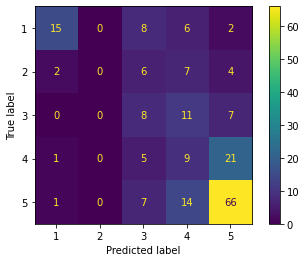

In [57]:
cmd = ConfusionMatrixDisplay.from_predictions(y_true, v_pred)
plt.show()

In [67]:
print(classification_report(y_true, v_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.79      0.48      0.60        31
           2       0.00      0.00      0.00        19
           3       0.24      0.31      0.27        26
           4       0.19      0.25      0.22        36
           5       0.66      0.75      0.70        88

    accuracy                           0.49       200
   macro avg       0.38      0.36      0.36       200
weighted avg       0.48      0.49      0.48       200



## TextBlob

[https://textblob.readthedocs.io/en/dev/](https://textblob.readthedocs.io/en/dev/)

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [59]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [60]:
blobs = [TextBlob(P.iloc[i].text) for i in range(P.shape[0])]
blobs[0].sentiment

Sentiment(polarity=0.4285714285714286, subjectivity=0.5169312169312169)

In [61]:
t_pred = []
for blob in blobs:
    s = blob.sentiment
    if s.polarity > 0.75:
        t_pred.append(5)
    elif 0.25 < s.polarity <= 0.75:
        t_pred.append(4)
    elif -0.25 < s.polarity <= 0.25:
        t_pred.append(3)
    elif -0.75 < s.polarity <= -0.25:
        t_pred.append(2)
    else:
        t_pred.append(1)

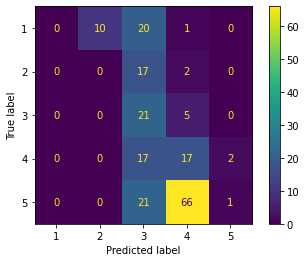

In [62]:
cmd = ConfusionMatrixDisplay.from_predictions(y_true, t_pred)
plt.show()

In [65]:
print(classification_report(y_true, t_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        19
           3       0.22      0.81      0.34        26
           4       0.19      0.47      0.27        36
           5       0.33      0.01      0.02        88

    accuracy                           0.20       200
   macro avg       0.15      0.26      0.13       200
weighted avg       0.21      0.20      0.10       200



# Exercize
- Choose one of Vader or TextBlob
- Try to explore a methodology for improving the naive performances achieved in this example
- *hint*: try to use polarity scores to train a classifier